Se instalan aquellas dependencias necesarias.

In [24]:
%pip install transformers
%pip install scipy
%pip install transformers pandas matplotlib
%pip install torch torchvision torchaudio
%pip install sentence_transformers

Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Importamos las librerias necesarias para el análisis.

In [48]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer,AutoModelForSequenceClassification,pipeline
from pysentimiento.preprocessing import preprocess_tweet
from pysentimiento import create_analyzer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

In [26]:
pd.set_option('display.max_colwidth', None)

In [27]:
df = pd.read_csv("300tweets.csv")

Se observa el % de datos nulos dentro del dataset.

In [28]:
total_rows = df.shape[0]
null_percentage = pd.DataFrame()
null_percentage = (df.isnull().sum() / total_rows*100 ).reset_index()
null_percentage.columns = ['variables','porcentaje']
null_percentage

,variables,porcentaje
0,Name,0.000000
1,Handle,0.000000
2,Media URL,74.309392
3,Retweets,94.198895
4,Likes,80.939227
5,Comments,66.850829
6,Views,0.276243
7,Tweet URL,0.000000
8,Profile Link,0.000000
9,Post Body,0.552486


Para el análisis de sentimiento no vamos a necesitar otra cosa que el "Post Body". Dejó "Tweet URL" y "Timestamp" para tener mas información sobre el tweet a fines prácticos.

In [29]:
df = df[['Tweet URL', 'Post Body', 'Timestamp']]
df.head()

,Tweet URL,Post Body,Timestamp
0,https://x.com/_antiKorrupcion/status/1796698692583293433,"... por favor limpien la esquina de Malaver y Maipú, es un basurero... está justo frente a la Quinta Presidencial!! ...escribo a esta cuenta ya q me cansé de mandar mails con fotos y hacer reclamos de manera presencial en la Municipalidad sin obtener respuestas... Gracias.",2024-06-01T00:22:04.000Z
1,https://x.com/bosqueymar22/status/1796563609201357087,Agarra el watsup que mande un mensaje hace 3 días. Mañana arranco a cortar los árboles de la puerta de casa con la motosierra. Se lleva cableado y corte de calle. El que avisa...,2024-05-31T15:25:17.000Z
2,https://x.com/MissARGSTVZ/status/1796359740152483890,Cuánto nos sale esta publicidad pedorra?,2024-05-31T01:55:11.000Z
3,https://x.com/PurvesCynthia/status/1796175455428530263,@VivamosVL además de lo verde cuiden la limpieza de la calle malaver que es un espanto,2024-05-30T13:42:54.000Z
4,https://x.com/normafe02654727/status/1796139636579770877,Pedí un turno para clínica medica y no me lo dieron por ser de pami soy vecina de vte.lopez y pago bastante de impuestos para que me atiendan.,2024-05-30T11:20:34.000Z


In [30]:
df.dtypes

Tweet URL    object
Post Body    object
Timestamp    object
dtype: object

Como se observa que son todos tipos de datos "object", para poder predecir el sentimiento se va a necesitar que Post Body sea un string. Para manejar mas facilmente la fecha se lo pone en un formato que corresponda.

In [31]:
df['Post Body'] = df['Post Body'].astype(str)
df['Timestamp'] = pd.to_datetime(df['Timestamp']).dt.date

Se hace un preprocesamiento mínimo para eliminar: @, URLs, #, emojis y caracteres especiales. Ademas de convertir todo el texto a minúsculas, descartar tweets vacios (que solo contenian menciones o hashtags) y tweets repetidos. Esto dejara el texto lo mas limpio posible para su futura predicción.

In [32]:
def clean_text(text):
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'#\S+', '', text) 
    text = re.sub(r'[^\w\s]', '', text) 
    text = text.lower()
    return text

df['Post Body'].replace('', pd.NA, inplace=True)
df.dropna(subset=['Post Body'], inplace=True)
df.drop_duplicates(subset=['Post Body'], inplace=True)

df['Post Body'] = df['Post Body'].apply(clean_text)

Se usa un tokenizador para separar las palabras.

In [33]:
tokenizer = AutoTokenizer.from_pretrained('pysentimiento/robertuito-base-cased')
list = []
for review in df['Post Body']:
    preprocessed_text = preprocess_tweet(review)
    
    list.append(tokenizer.tokenize(preprocessed_text))

In [34]:
tokenized_tweets = [' '.join(tokens) for tokens in list]

In [35]:
df_tokenized = pd.DataFrame({'Tweets tokenizados': tokenized_tweets})
df_tokenized

,reseñas_tokenizadas
0,▁por ▁favor ▁limp ien ▁la ▁esquina ▁de ▁mala ver ▁y ▁ma ip ú ▁ ▁es ▁un ▁bas ur ero ▁está ▁justo ▁frente ▁a ▁la ▁quinta ▁presidencial ▁escribo ▁a ▁esta ▁cuenta ▁ya ▁q ▁me ▁cansé ▁de ▁mandar ▁ma ils ▁con ▁fotos ▁y ▁hacer ▁reclamos ▁de ▁manera ▁presencial ▁en ▁la ▁municipal idad ▁sin ▁ ▁obtener ▁respuestas ▁gracias
1,▁agarra ▁el ▁w ats up ▁que ▁mande ▁un ▁mensaje ▁hace ▁3 ▁días ▁ ▁mañana ▁arranco ▁a ▁cortar ▁los ▁árboles ▁de ▁la ▁puerta ▁de ▁casa ▁con ▁la ▁motos ierra ▁se ▁lleva ▁cable ado ▁y ▁corte ▁de ▁calle ▁el ▁que ▁avisa
2,▁cuánto ▁nos ▁sale ▁esta ▁publicidad ▁pedor ra
3,▁además ▁de ▁lo ▁verde ▁cuiden ▁la ▁limpieza ▁de ▁la ▁calle ▁mala ver ▁que ▁es ▁un ▁esp anto
4,▁pedí ▁un ▁turno ▁para ▁clínica ▁medica ▁y ▁no ▁me ▁lo ▁dieron ▁por ▁ser ▁de ▁pa mi ▁soy ▁vecina ▁de ▁v telo pez ▁y ▁pago ▁bastante ▁de ▁impuestos ▁para ▁que ▁me ▁at iendan
...,...
333,▁excelente ▁plan ▁de ▁conci en tiza cion
334,▁hace ▁45 ▁días ▁levante ▁reclamo ▁por ▁el ▁14 7 ▁por ▁un ▁enorme ▁ba che ▁en ▁calle ▁tomaron ▁pedido ▁respon dieron ▁esta ▁solucion ado ▁perdón ▁nunca ▁vinieron ▁cada ▁vez ▁peor ▁esta ▁y ▁nadie ▁viene ▁ra w son ▁al ▁4 000
335,▁quiero ▁saber ▁de ▁paso ▁quien ▁pago ▁y ▁cuanto ▁salió ▁el ▁brind is ▁de ▁instituciones ▁la ▁semana ▁pasada
336,▁justo ▁frente ▁a ▁donde ▁hicieron ▁el ▁control ▁libertador ▁18 50 ▁la ▁agencia ▁to yo ta ▁flia ▁macri ▁se ▁caga ▁en ▁todos ▁los ▁vecinos ▁estacion ado ▁sus ▁autos ▁y ▁ocu pando ▁toda ▁la ▁vereda ▁los ▁peat ones ▁tienen ▁que ▁bajar ▁a ▁la ▁vereda ▁para ▁poder ▁trans itar ▁la ▁gente ▁de ▁tránsito ▁nunca ▁hace ▁nada ▁far s antes


In [36]:
analyzer = create_analyzer(task="sentiment", lang="es")

pred = analyzer.predict(df_tokenized["reseñas_tokenizadas"])

Map:   0%|          | 0/338 [00:00<?, ? examples/s]

Se puede ver en el output de "pred" el sentimiento que determino el modelo para cada tweet junto con el porcentaje de negatividad, positividad y neutralidad.

In [37]:
pred[0]

AnalyzerOutput(output=NEG, probas={NEG: 0.885, NEU: 0.105, POS: 0.010})

Se guarda junta a cada tweet el sentimiento de este.

In [38]:
df['Sentiment'] = [p.output for p in pred]

In [39]:
negative_tweets = df[df['Sentiment'] == 'NEG']

Ahora "negative_tweets" es un df con todas los tweets determinados como negativos.

# Una vez clasificados los tweets, podemos hacer las siguientes cosas:

* Clasificación de temas

 Se aplica el algoritmo de LDA para clasificación.

Las stopwords son aquellas palabras que queremos evitar que se consideren ya que no nos sirven.

In [40]:
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['todos','les','día','cuando','les','gracias','mas','pasa','estamos','mi','están','va','qué','este','esta','pero','dan','van','nos','esto','si','hace','nada','ni','está','eso','toda','desde','todo','una','sin','un','ya','estan','hacer','hay','más','ausol_ar','vivamosvl','solucionar', 'puede', 'pueden', 'han', 'es', 'son', 'porque', 'donde', 'que', 'la', 'el', 'de', 'y', 'a', 'en', 'los', 'del', 'se', 'por', 'con', 'para', 'como', 'al', 'le', 'lo', 'las', 'sus'])
custom_stopwords = list(custom_stopwords)

vectorizer = CountVectorizer(max_df=0.5, min_df=1, stop_words=custom_stopwords)
X = vectorizer.fit_transform(negative_tweets["Post Body"])

lda = LatentDirichletAllocation(n_components=10, random_state=2)
lda.fit(X)

for index, topic in enumerate(lda.components_):
    print(f'Tema {index}:')
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])


c:\Users\Pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


Tema 0:
['algo', 'reclamos', 'dia', 'semana', 'limpieza', 'calle', '3145', 'luz', 'mariano', 'pelliza']
Tema 1:
['abl', 'mandar', 'frente', 'calle', 'favor', 'días', 'municipio', 'mugre', 'vecinos', 'reclamos']
Tema 2:
['mugre', 'lópez', 'alumbrado', 'solucionado', 'sigue', 'reclamo', 'entre', 'reclamos', 'vicente', 'meses']
Tema 3:
['tengo', 'días', '147', 'solo', 'abl', 'puerta', 'casa', 'nunca', 'nadie', 'tiempo']
Tema 4:
['pasó', 'favor', 'tasas', 'barrio', 'arreglen', 'nadie', 'impuestos', 'municipio', 'luminaria', 'florida']
Tema 5:
['sobre', 'clausura', 'semana', 'vicente', 'suerte', 'calles', 'vez', 'hojas', 'hola', 'florida']
Tema 6:
['dias', 'lleno', 'municipalidad', 'te', 'caso', 'impuestos', 'semanas', 'calle', 'luminaria', 'luz']
Tema 7:
['poda', 'meses', 'años', 'poner', 'calle', 'acá', 'entre', 'florida', 'vecinos', 'favor']
Tema 8:
['semana', 'tengo', 'dos', 'calle', 'florida', 'mes', 'calles', 'vecinos', 'basura', 'impuestos']
Tema 9:
['vez', 'barrio', 'cuadra', 'autos

Al haber pocos datos no da mucha certeza esta clasificación. Lo que si podemos identificar palabras clave de los tópicos mas tratados: impuestos, fumigación, iluminaria, limpieza, etc.

* Se puede hacer una clasificación en temas. Es decir, los tweets que comparten el mismo tema tienen un conjunto de palabras similares que ocurren frecuentemente juntas, lo cual puede indicar que tratan sobre un tema similar. Esto puede utilizarse para futuras predicciones para clasificar tweets por temas.

In [41]:
topic_distributions = lda.transform(X)

topic_df = pd.DataFrame(topic_distributions, columns=[f'Tema {i}' for i in range(10)])
topic_df['Dominant Topic'] = topic_df.idxmax(axis=1)

topic_df.head()

,Tema 0,Tema 1,Tema 2,Tema 3,Tema 4,Tema 5,Tema 6,Tema 7,Tema 8,Tema 9,Dominant Topic
0,0.004348,0.960868,0.004348,0.004348,0.004348,0.004348,0.004348,0.004348,0.004348,0.004348,Tema 1
1,0.005556,0.005556,0.005556,0.949997,0.005556,0.005556,0.005557,0.005556,0.005556,0.005556,Tema 3
2,0.020002,0.020000,0.020002,0.020002,0.020000,0.020003,0.020000,0.819989,0.020000,0.020002,Tema 7
3,0.887491,0.012502,0.012501,0.012500,0.012501,0.012501,0.012501,0.012501,0.012500,0.012501,Tema 0
4,0.006667,0.006667,0.006667,0.006667,0.939997,0.006667,0.006667,0.006667,0.006667,0.006667,Tema 4


In [42]:
df['Dominant Topic'] = topic_df['Dominant Topic']

* En este caso se usa para visualización de los datos. Una especie de nube de palabras para cada tema.

In [43]:
no_top_words = 10
tf_feature_names = vectorizer.get_feature_names_out()

Palabras más comunes del Tema 0:


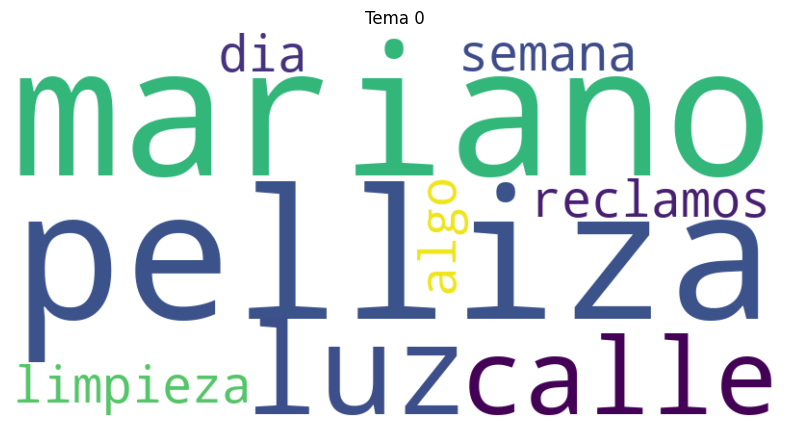

Palabras más comunes del Tema 1:


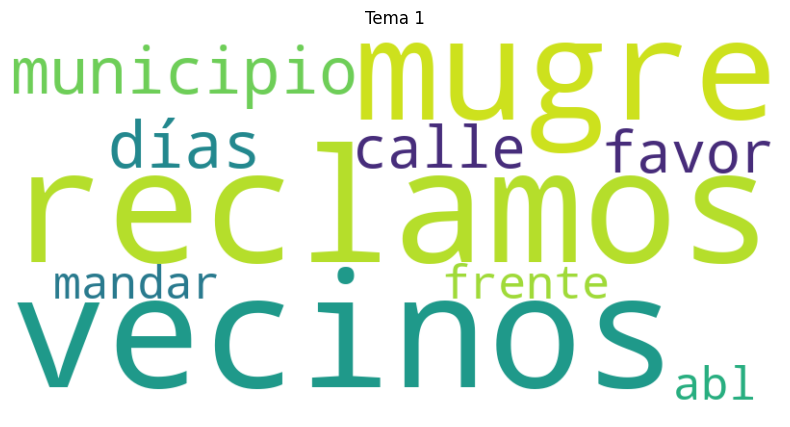

Palabras más comunes del Tema 2:


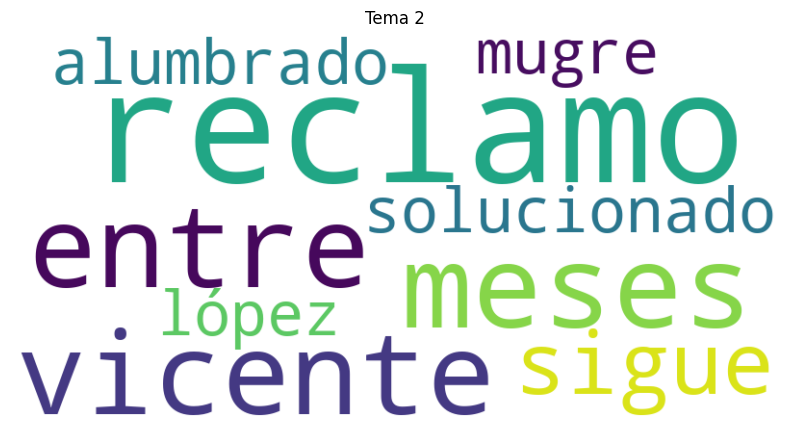

Palabras más comunes del Tema 3:


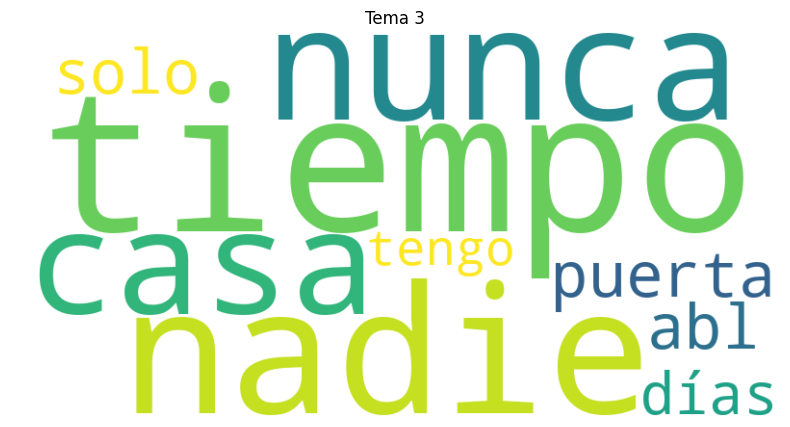

Palabras más comunes del Tema 4:


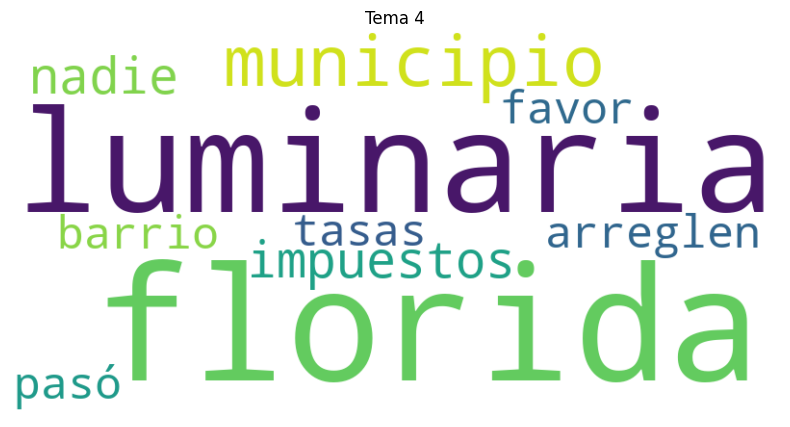

Palabras más comunes del Tema 5:


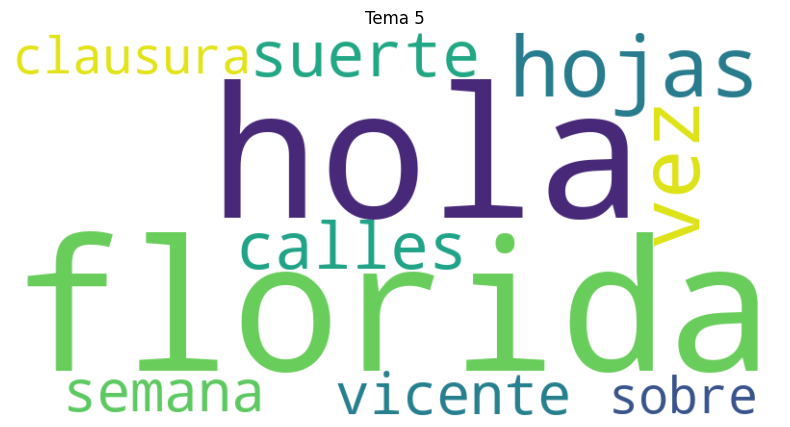

Palabras más comunes del Tema 6:


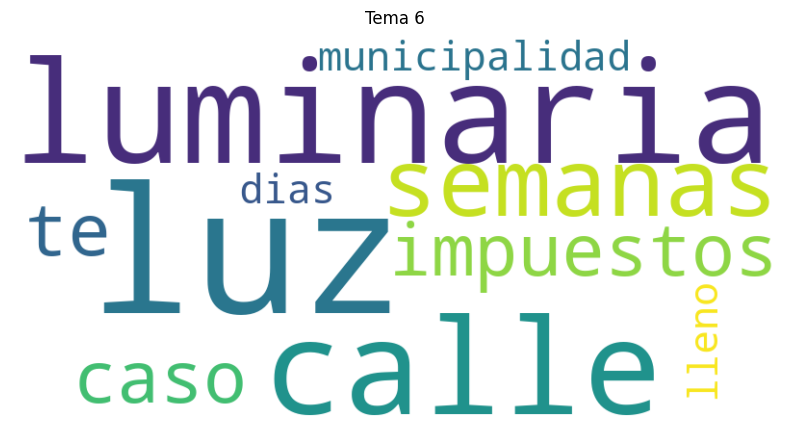

Palabras más comunes del Tema 7:


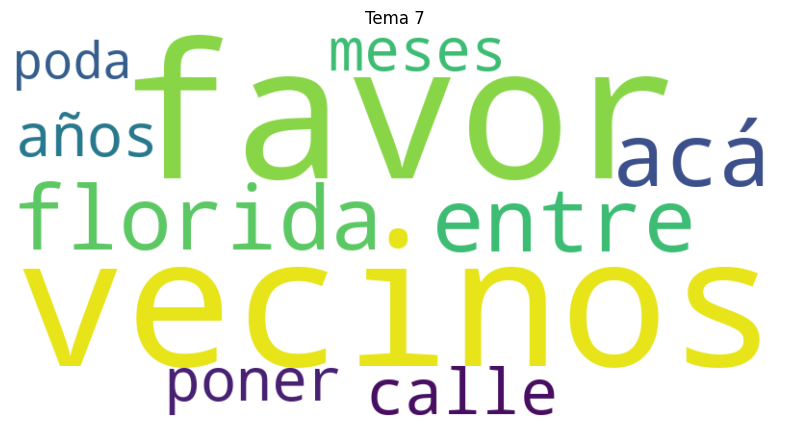

Palabras más comunes del Tema 8:


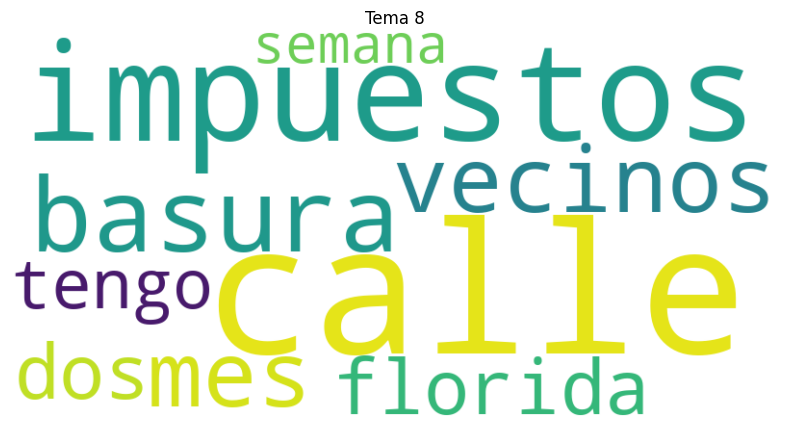

Palabras más comunes del Tema 9:


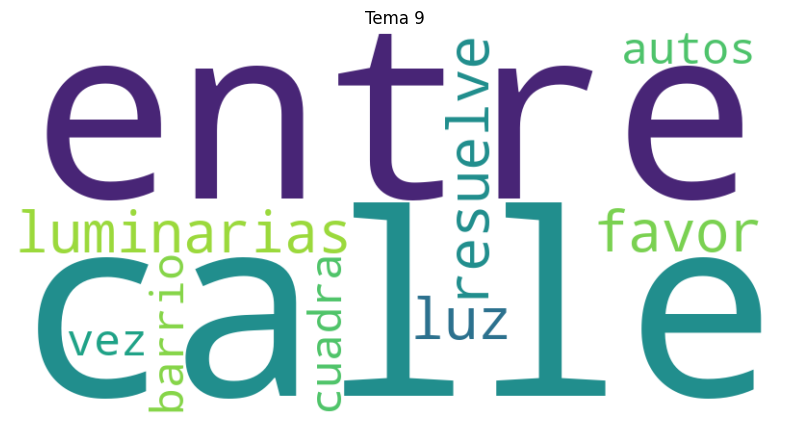

In [44]:
for topic_idx, topic in enumerate(lda.components_):
    print(f"Palabras más comunes del Tema {topic_idx}:")
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join([tf_feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Tema {topic_idx}")
    plt.show()

* En este caso vemos una distribución de temas en un heatmap.

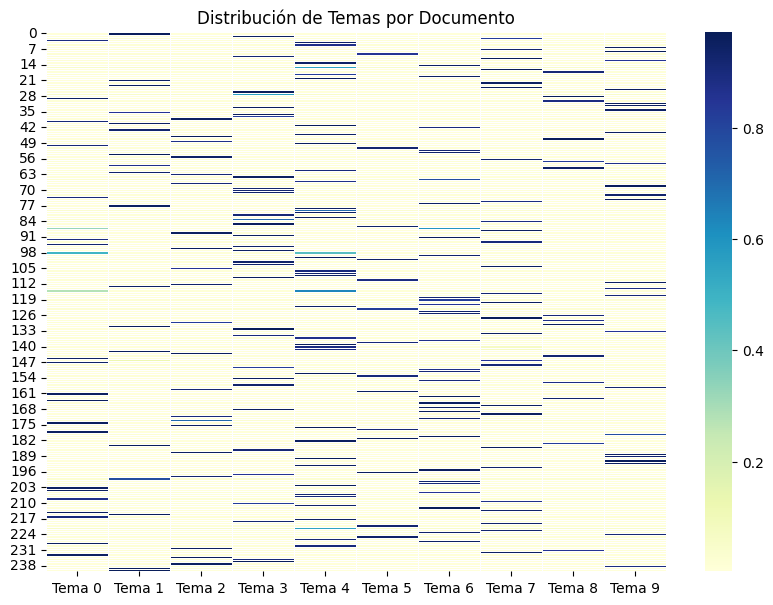

In [45]:
plt.figure(figsize=(10, 7))
sns.heatmap(topic_df.drop(columns=['Dominant Topic']), cmap="YlGnBu", linewidths=.5)
plt.title("Distribución de Temas por Documento")
plt.show()

* Otra cosas que se pueden agregar.

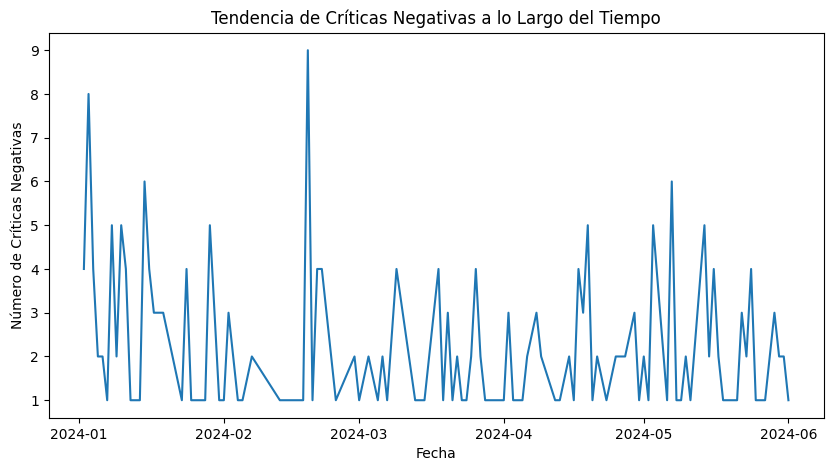

In [46]:
negative_dates = df[df['Sentiment'] == 'NEG'].groupby('Timestamp').size()

plt.figure(figsize=(10, 5))
negative_dates.plot(kind='line')
plt.title('Tendencia de Críticas Negativas a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Número de Críticas Negativas')
plt.show()

Se muestran las 5 fechas con más críticas negativas.

In [47]:
negative_dates_sorted = negative_dates.sort_values(ascending=False)
top_negative_dates = negative_dates_sorted.head(5)
top_negative_dates

Timestamp
2024-02-19    9
2024-01-03    8
2024-05-07    6
2024-01-15    6
2024-04-19    5
dtype: int64